# Lab 6 - CNNs
#### Liam Lowsley-Williams, Fernando Vázquez


## Business Case

### Motivation

### Objective

### Evaluation

## Function & Package Intialization
#### DONT FORGET TO SWITCH KERNEL TO GPU!!!

In [1]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please ensure you have installed TensorFlow correctly')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 2.0.0
Default GPU Device: /device:GPU:0


In [2]:
import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping

from sklearn import metrics as mt
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import pickle
import numpy as np

# graph visualization
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

keras.__version__

Using TensorFlow backend.


'2.3.1'

In [57]:
def compare_mlp_cnn(cnn, mlp, X_test, y_test):
    plt.figure(figsize=(45,20))
    if cnn is not None:
        yhat_cnn = np.argmax(cnn.predict(np.expand_dims(X_test, axis=1)), axis=1)
        acc_cnn = mt.accuracy_score(y_test,yhat_cnn)
        plt.subplot(1,2,1)
        cm = mt.confusion_matrix(y_test,yhat_cnn)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f')
        plt.title('CNN: '+str(acc_cnn))
    
    if mlp is not None:
        yhat_mlp = np.argmax(mlp.predict(X_test), axis=1)
        acc_mlp = mt.accuracy_score(y_test,yhat_mlp)
        plt.subplot(1,2,2)
        cm = mt.confusion_matrix(y_test,yhat_mlp)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm,annot=True, fmt='.2f')
        plt.title('MLP: '+str(acc_mlp))
        
def compare_mlp_cnn_tr(cnn, mlp, X_test, y_test):
    plt.figure(figsize=(45,20))
    if cnn is not None:
        yhat_cnn = np.argmax(cnn.predict(X_test), axis=1)
        acc_cnn = mt.accuracy_score(y_test,yhat_cnn)
        plt.subplot(1,2,1)
        cm = mt.confusion_matrix(y_test,yhat_cnn)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f')
        plt.title('CNN: '+str(acc_cnn))
    
    if mlp is not None:
        yhat_mlp = np.argmax(mlp.predict(X_test), axis=1)
        acc_mlp = mt.accuracy_score(y_test,yhat_mlp)
        plt.subplot(1,2,2)
        cm = mt.confusion_matrix(y_test,yhat_mlp)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm,annot=True, fmt='.2f')
        plt.title('MLP: '+str(acc_mlp))

def cnn_heatmap(cnn, X_test, y_test):
    plt.figure(figsize=(45,20))
    if cnn is not None:
        yhat_cnn = np.argmax(cnn.predict(X_test), axis=1)
        acc_cnn = mt.accuracy_score(y_test,yhat_cnn)
        plt.subplot(1,2,1)
        cm = mt.confusion_matrix(y_test,yhat_cnn)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f')
        plt.title('CNN: '+str(acc_cnn))

## Data Processing

### TRAFFIC PREPROCESS

In [5]:
# select random images to visualize
import random
random.seed(1)

# function to plot images in grid like fashion
def plot_gallery(images, title, h, w, n_row=4, n_col=8):
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    rand_sample = random.sample(range(0,images.shape[0]), k=32)
    n = 0
    for i in rand_sample:
        plt.subplot(n_row, n_col, n + 1)
        plt.imshow(images[i][0])
        plt.title(title[i], size=12)
        plt.xticks(())
        plt.yticks(())
        n = n+1

In [6]:
file = open("./data/traffic/data3.pickle", "rb")
data = pickle.load(file) 

In [7]:
X_train_tr = data['x_train']
X_test_tr = data['x_test']
y_train_tr = data['y_train']
y_test_tr = data['y_test']

In [8]:
np.transpose(X_train_tr[500], (2, 1, 0)).shape

(32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


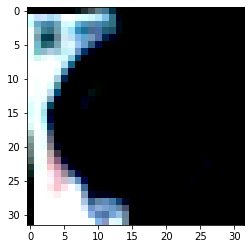

In [9]:
# np.transpose(img, (1, 2, 0))

plt.imshow(np.transpose(X_train_tr[500], (2, 1, 0)), interpolation='nearest')

# plt.imshow(X_train_tr[500][2], interpolation='nearest')


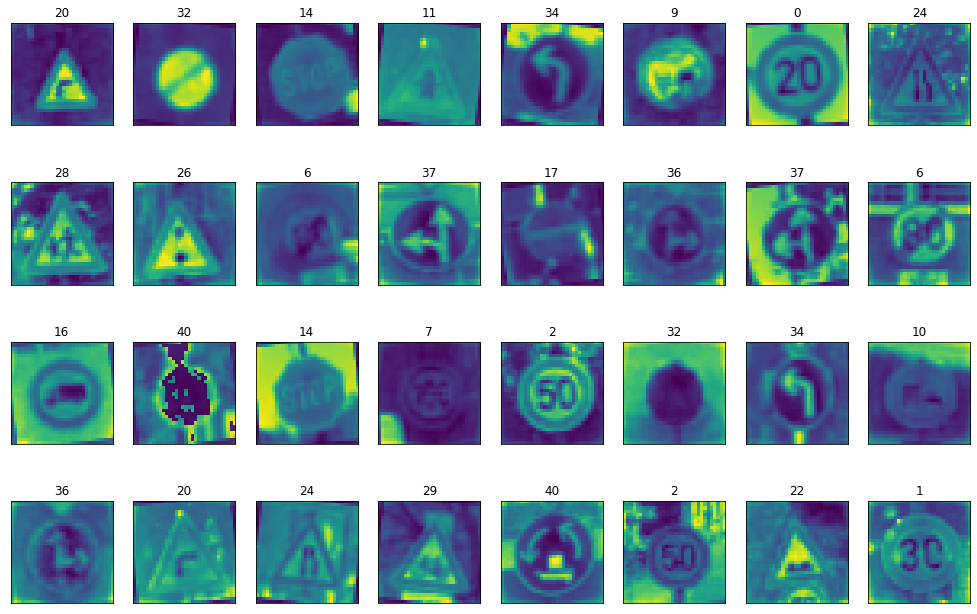

In [10]:
plot_gallery(X_train_tr, y_train_tr,32,32)

In [11]:
X_train_tr.shape

(86989, 3, 32, 32)

In [12]:
X_train_tr[0].shape

(3, 32, 32)

In [13]:
y_train_ohe_tr = keras.utils.to_categorical(y_train_tr, 43)
y_test_ohe_tr = keras.utils.to_categorical(y_test_tr, 43)

## Modeling

In [14]:
## QUESTIONS ##
'''
1. Is the way we are feeding data into CNN correct?
2. Reccomendations on structures that will work well with our data? How to go about constructing them?
3. Which params exactly are the ones we should tune?
4. How would we go about data expansion if we use the preprocessed pickle files? Can we perform on data8
   which has shuffling, histogram equalization, and mean + std normalization? (not flattened)
5. Ask about which activation functions should be linear or relu
6. If we use the "validation_data" param, as seen below (curently uses the test data to validate), do we 
   need to use a third validation data set? If so, then where do we predict that? After the fit?
'''

'\n1. Is the way we are feeding data into CNN correct?\n2. Reccomendations on structures that will work well with our data? How to go about constructing them?\n3. Which params exactly are the ones we should tune?\n4. How would we go about data expansion if we use the preprocessed pickle files? Can we perform on data8\n   which has shuffling, histogram equalization, and mean + std normalization? (not flattened)\n5. Ask about which activation functions should be linear or relu\n6. If we use the "validation_data" param, as seen below (curently uses the test data to validate), do we \n   need to use a third validation data set? If so, then where do we predict that? After the fit?\n'

### Architecture 1 - Param Set 1

In [15]:
'''
INIT ARCHITECTURE
'''
img_sz = 32 # width and height of img

cnn1 = Sequential()

num_filt_layers = [24, 24]
for num_filters in num_filt_layers:
    cnn1.add( Conv2D(filters=num_filters, 
                     kernel_size=(3,3), 
                     padding='same',
                     data_format="channels_first") 
            )
    cnn1.add( Activation('relu'))
    cnn1.add( MaxPooling2D(pool_size=(2, 2), data_format="channels_first") )
    
cnn1.add( Flatten() )
cnn1.add( Dense(100, activation='relu') )
cnn1.add( Dense(100, activation='relu') )
cnn1.add( Dense(43, activation='softmax') )

cnn1.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

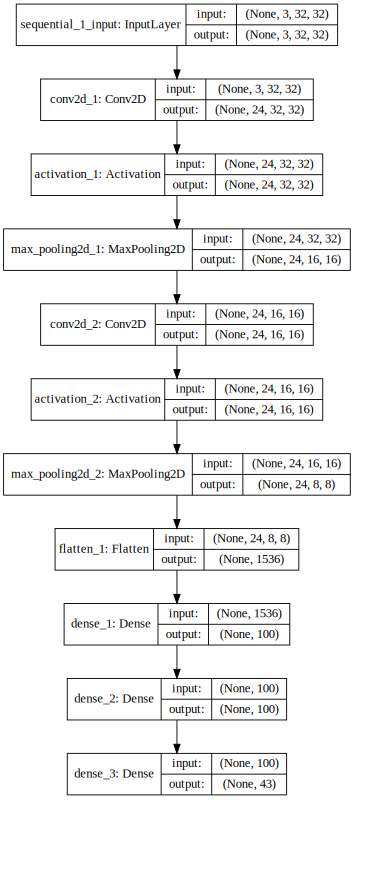

In [27]:
SVG(model_to_dot(cnn1, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

In [17]:
%%time
# DATA FORMAT -> (channels, x-dim, y-dim)
cnn1_hist = cnn1.fit(X_train_tr, y_train_ohe_tr, 
         batch_size=32, 
         epochs=15, 
         shuffle=True, 
         verbose=1,
         validation_data=(X_test_tr,y_test_ohe_tr),
         callbacks=[EarlyStopping(monitor='val_loss', patience=2)]
        )

Train on 86989 samples, validate on 12630 samples
Epoch 1/15
86989/86989 [==============================] - 21s 242us/step - loss: 0.0061 - accuracy: 0.7996 - val_loss: 0.0046 - val_accuracy: 0.8698
Epoch 2/15
86989/86989 [==============================] - 18s 212us/step - loss: 0.0016 - accuracy: 0.9562 - val_loss: 0.0033 - val_accuracy: 0.9095
Epoch 3/15
86989/86989 [==============================] - 19s 222us/step - loss: 0.0011 - accuracy: 0.9696 - val_loss: 0.0034 - val_accuracy: 0.9094
Epoch 4/15
86989/86989 [==============================] - 19s 217us/step - loss: 9.1787e-04 - accuracy: 0.9755 - val_loss: 0.0038 - val_accuracy: 0.9021
Wall time: 1min 18s


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


Text(0.5, 0, 'epochs')

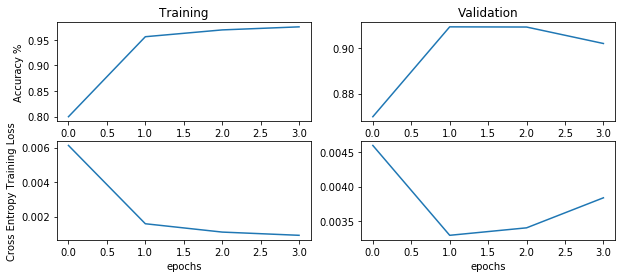

In [25]:
print(cnn1_hist.history.keys())
plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(cnn1_hist.history['accuracy'])

plt.ylabel('Accuracy %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(cnn1_hist.history['val_accuracy'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(cnn1_hist.history['loss'])
plt.ylabel('Cross Entropy Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(cnn1_hist.history['val_loss'])
plt.xlabel('epochs')

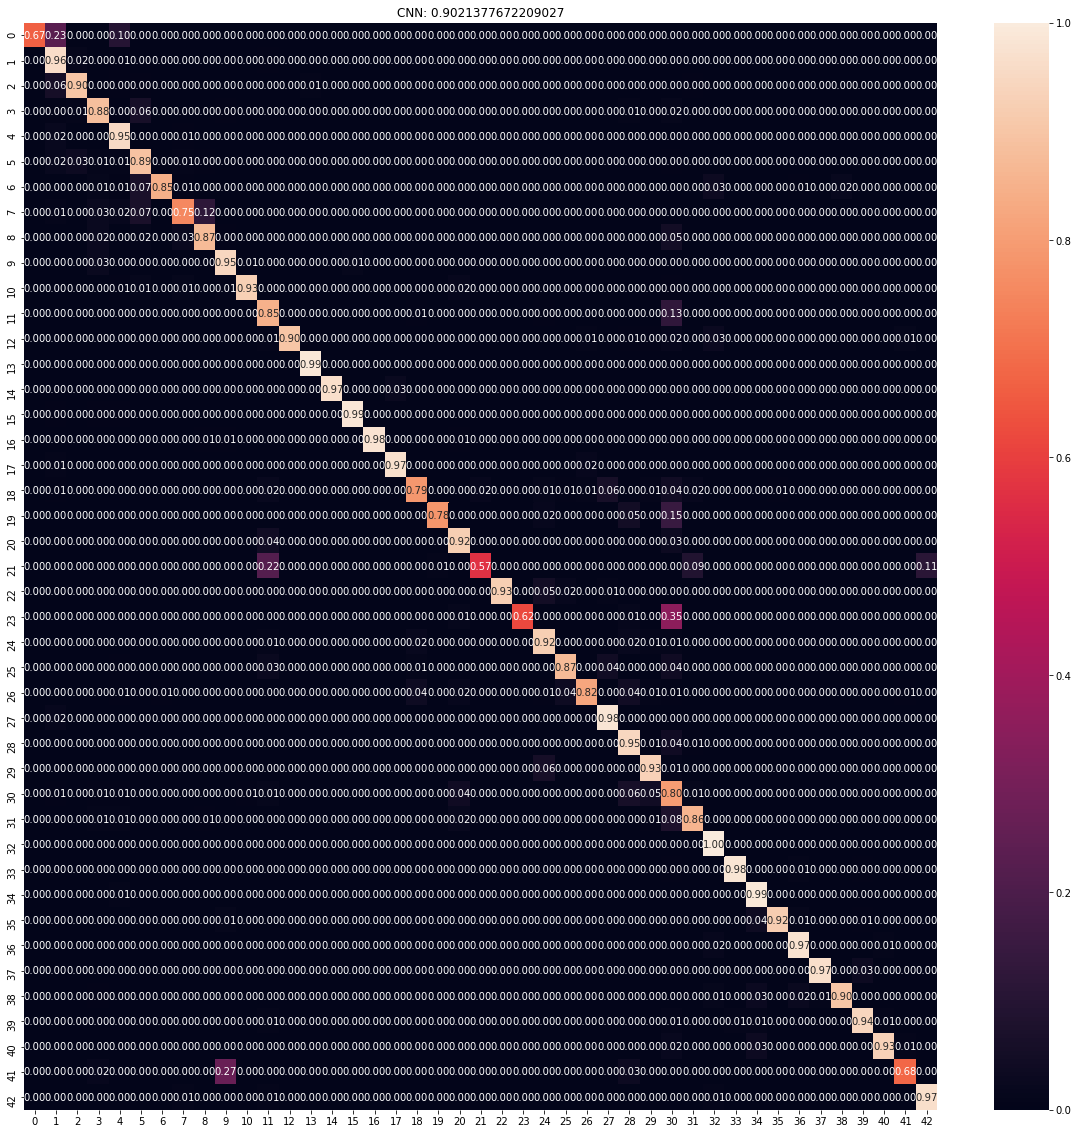

In [26]:
cnn_heatmap(cnn1,X_test_tr,y_test_tr)

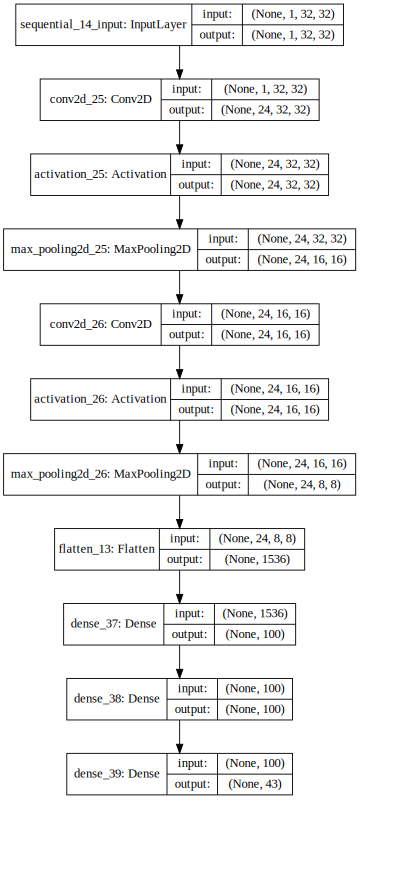

### Architecture 1 - Param Set 2

In [28]:
'''
CHANGES:
 - DOUBLED SIZE OF SECOND FILTER LAYER
 - INCREASED SIZE OF KERNEL TO (4,4)
 - CHANGED THE ACTIVATION FUNCTION IN THE 2 DENSE LAYERS TO LINEAR
'''

img_sz = 32 # width and height of img

cnn2 = Sequential()
num_filt_layers = [24, 48]
for num_filters in num_filt_layers:
    cnn2.add( Conv2D(filters=num_filters, 
                     kernel_size=(4,4), 
                     padding='same',
                     data_format="channels_first") 
            )
    cnn2.add( Activation('relu'))
    cnn2.add( MaxPooling2D(pool_size=(2, 2), data_format="channels_first") )
    
cnn2.add( Flatten() )
cnn2.add( Dense(100, activation='linear') )
cnn2.add( Dense(100, activation='linear') )
cnn2.add( Dense(43, activation='softmax') )

cnn2.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

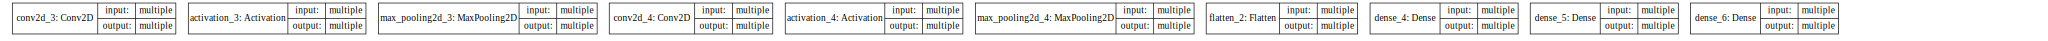

In [29]:
SVG(model_to_dot(cnn2, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

In [30]:
%%time
# DATA FORMAT -> (channels, x-dim, y-dim)
cnn2_hist = cnn2.fit(X_train_tr, y_train_ohe_tr, 
         batch_size=32, 
         epochs=15, 
         shuffle=True, 
         verbose=1,
         validation_data=(X_test_tr,y_test_ohe_tr),
         callbacks=[EarlyStopping(monitor='val_loss', patience=2)]
        )

Train on 86989 samples, validate on 12630 samples
Epoch 1/15
86989/86989 [==============================] - 21s 240us/step - loss: 0.0046 - accuracy: 0.8535 - val_loss: 0.0042 - val_accuracy: 0.8910
Epoch 2/15
86989/86989 [==============================] - 20s 229us/step - loss: 0.0016 - accuracy: 0.9573 - val_loss: 0.0034 - val_accuracy: 0.9142
Epoch 3/15
86989/86989 [==============================] - 21s 236us/step - loss: 0.0014 - accuracy: 0.9642 - val_loss: 0.0031 - val_accuracy: 0.9245
Epoch 4/15
86989/86989 [==============================] - 20s 234us/step - loss: 0.0013 - accuracy: 0.9672 - val_loss: 0.0041 - val_accuracy: 0.9054
Epoch 5/15
86989/86989 [==============================] - 20s 234us/step - loss: 0.0013 - accuracy: 0.9681 - val_loss: 0.0038 - val_accuracy: 0.9130
Wall time: 1min 42s


Text(0.5, 0, 'epochs')

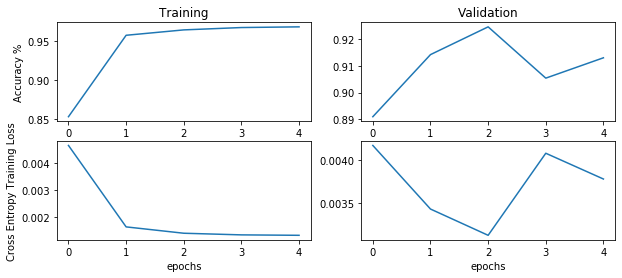

In [31]:
plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(cnn2_hist.history['accuracy'])

plt.ylabel('Accuracy %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(cnn2_hist.history['val_accuracy'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(cnn2_hist.history['loss'])
plt.ylabel('Cross Entropy Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(cnn2_hist.history['val_loss'])
plt.xlabel('epochs')

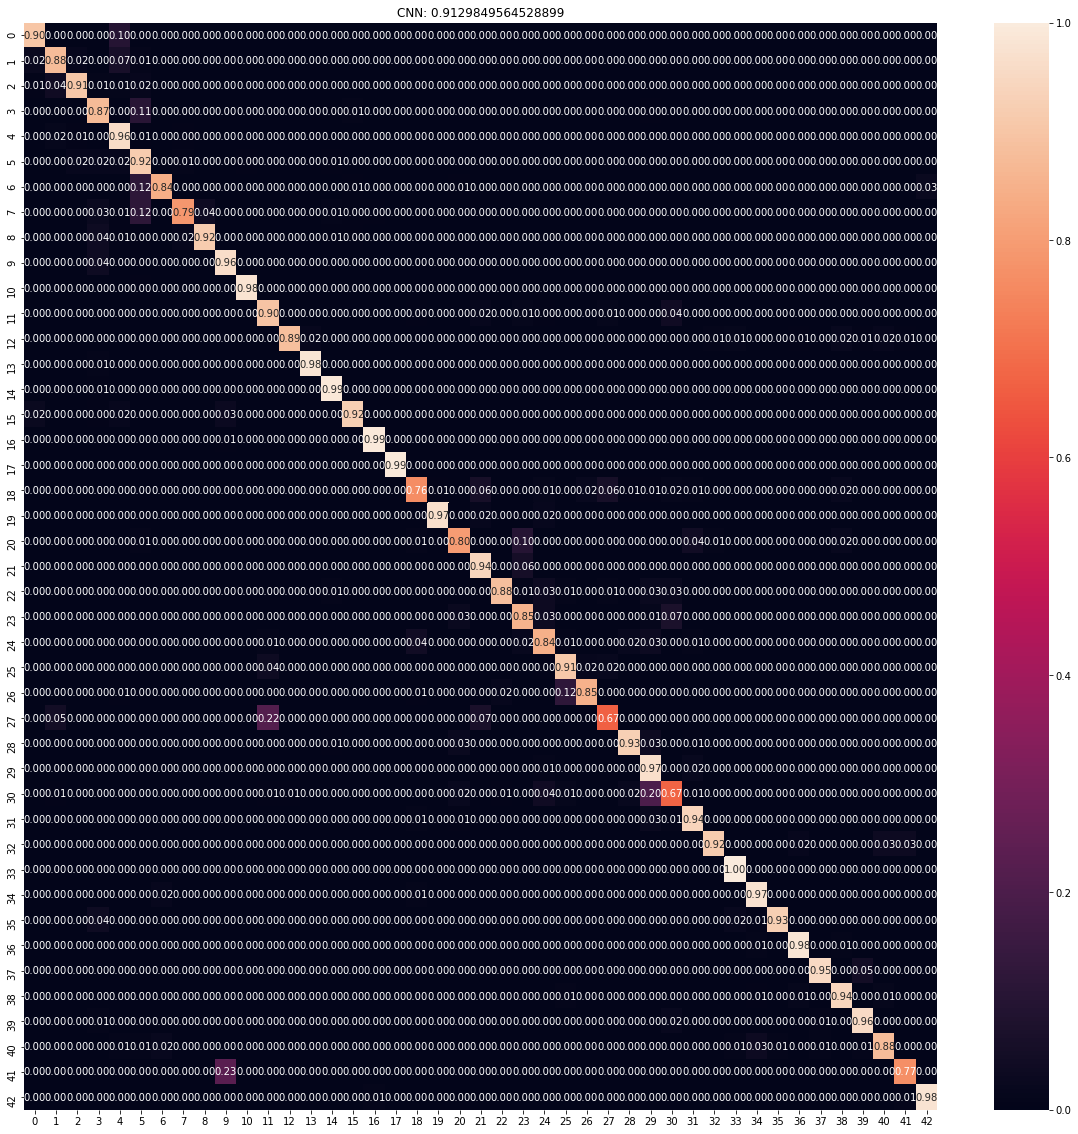

In [32]:
cnn_heatmap(cnn2,X_test_tr,y_test_tr)

### Architecture 2 - Param Set 1

In [33]:
'''
INIT ARCHCITECTURE
'''
img_sz = 32 # width and height of img

cnn3 = Sequential()

# 1st Convolutional Layer w/pool
cnn3.add(Conv2D(filters=96, 
                kernel_size=(5,5), 
                strides=(4,4), 
                padding='same',
                data_format="channels_first"))
cnn3.add(Activation('relu'))
cnn3.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# 2nd Convolutional Layer w/pool
cnn3.add(Conv2D(filters=256, 
                  kernel_size=(5,5), 
                  strides=(1,1), 
                  padding='same',
                  data_format="channels_first"))
cnn3.add(Activation('relu'))
cnn3.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# 3rd Convolutional Layer
cnn3.add(Conv2D(filters=384, 
                 kernel_size=(3,3), 
                 strides=(1,1), 
                 padding='same',
                 data_format="channels_first"))
cnn3.add(Activation('relu'))

# 4th Convolutional Layer
cnn3.add(Conv2D(filters=384, 
                 kernel_size=(3,3), 
                 strides=(1,1), 
                 padding='same',
                 data_format="channels_first"))
cnn3.add(Activation('relu'))

# 5th Convolutional Layer w/pool
cnn3.add(Conv2D(filters=256, 
                 kernel_size=(3,3), 
                 strides=(1,1), 
                 padding='same',
                 data_format="channels_first"))
cnn3.add(Activation('relu'))
cnn3.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))


# Passing to fully connected layer
cnn3.add(Flatten())
# 1st fully Connected Layer
cnn3.add(Dense(4096, input_shape=(img_sz*img_sz*3,), activation='relu'))
# cnn3.add(Activation('relu'))
# Add dropout to prevent overfitting
cnn3.add(Dropout(0.4))

# 2nd fully connected Layer
cnn3.add(Dense(4096, activation='relu'))
# cnn3.add(Activation('relu'))
cnn3.add(Dropout(0.4))

# 3rd fully connected Layer
cnn3.add(Dense(1000, activation='relu'))
# cnn3.add(Activation('relu'))
cnn3.add(Dropout(0.4))

# Output Layer
cnn3.add(Dense(43, activation='softmax'))
# cnn3.add(Activation('softmax'))

cnn3.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy']) 

In [34]:
SVG(model_to_dot(cnn3, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

In [35]:
%%time
# DATA FORMAT -> (channels, x-dim, y-dim)
cnn3_hist = cnn3.fit(X_train_tr, y_train_ohe_tr, 
         batch_size=32, 
         epochs=15, 
         shuffle=True, 
         verbose=1,
         validation_data=(X_test_tr,y_test_ohe_tr),
         callbacks=[EarlyStopping(monitor='val_loss', patience=2)]
        )

Train on 86989 samples, validate on 12630 samples
Epoch 1/15
86989/86989 [==============================] - 115s 1ms/step - loss: 0.0227 - accuracy: 0.0222 - val_loss: 0.0227 - val_accuracy: 0.0071
Epoch 2/15
86989/86989 [==============================] - 114s 1ms/step - loss: 0.0227 - accuracy: 0.0228 - val_loss: 0.0227 - val_accuracy: 0.0095
Epoch 3/15
86989/86989 [==============================] - 115s 1ms/step - loss: 0.0227 - accuracy: 0.0219 - val_loss: 0.0227 - val_accuracy: 0.0119
Epoch 4/15
86989/86989 [==============================] - 110s 1ms/step - loss: 0.0227 - accuracy: 0.0223 - val_loss: 0.0227 - val_accuracy: 0.0380
Epoch 5/15
86989/86989 [==============================] - 109s 1ms/step - loss: 0.0227 - accuracy: 0.0246 - val_loss: 0.0227 - val_accuracy: 0.0144
Epoch 6/15
86989/86989 [==============================] - 109s 1ms/step - loss: 0.0217 - accuracy: 0.0957 - val_loss: 0.0207 - val_accuracy: 0.1344
Epoch 7/15
86989/86989 [==============================] - 110s

Text(0.5, 0, 'epochs')

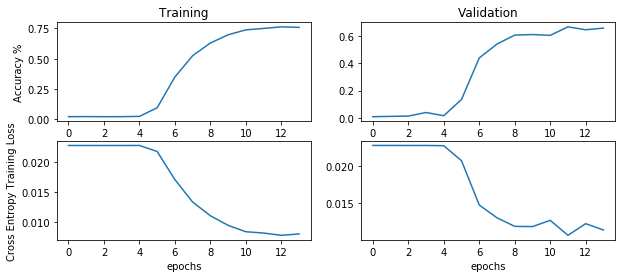

In [36]:
plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(cnn3_hist.history['accuracy'])

plt.ylabel('Accuracy %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(cnn3_hist.history['val_accuracy'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(cnn3_hist.history['loss'])
plt.ylabel('Cross Entropy Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(cnn3_hist.history['val_loss'])
plt.xlabel('epochs')

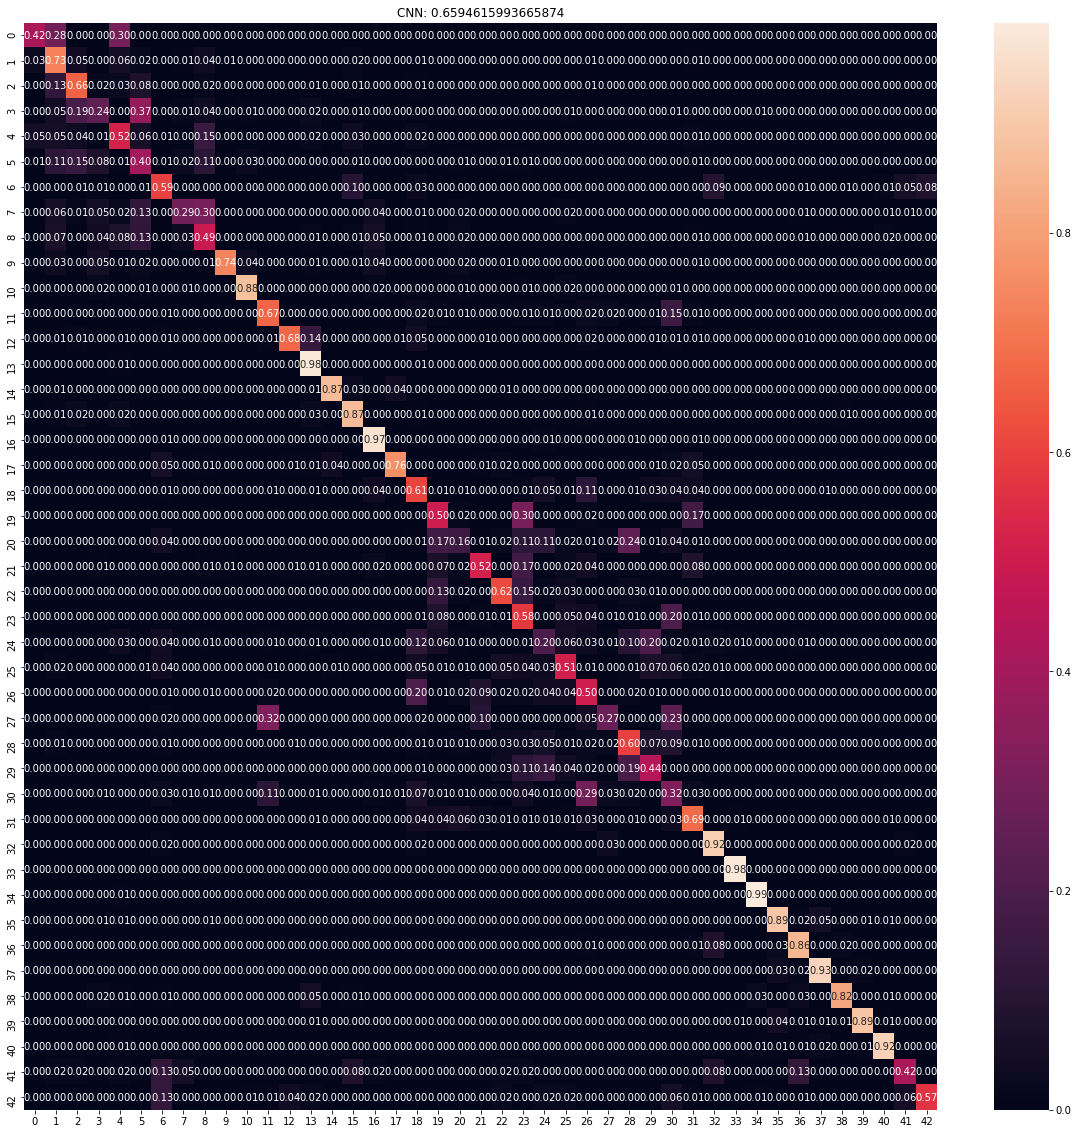

In [37]:
cnn_heatmap(cnn3,X_test_tr,y_test_tr)

### Architecture 2 - Param Set 2

In [38]:
'''
CHANGES:
 - filter sizes changed to 128 -> 256 -> 384 -> 256 -> 128
 - kernel sized changed to use 6x6 in 1st 2 conv layers and 3x3 in the last 3 conv layers
 - fully connected layers changed to 4096 -> 2048 -> 1024 neurons in each layer repectively
'''
img_sz = 32 # width and height of img

cnn4 = Sequential()

# 1st Convolutional Layer w/pool
cnn4.add(Conv2D(filters=128, 
                kernel_size=(6,6), 
                strides=(4,4), 
                padding='same',
                data_format="channels_first"))
cnn4.add(Activation('relu'))
cnn4.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# 2nd Convolutional Layer w/pool
cnn4.add(Conv2D(filters=256, 
                  kernel_size=(5,5), 
                  strides=(1,1), 
                  padding='same',
                  data_format="channels_first"))
cnn4.add(Activation('relu'))
cnn4.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# 3rd Convolutional Layer
cnn4.add(Conv2D(filters=384, 
                 kernel_size=(3,3), 
                 strides=(1,1), 
                 padding='same',
                 data_format="channels_first"))
cnn4.add(Activation('relu'))

# 4th Convolutional Layer
cnn4.add(Conv2D(filters=256, 
                 kernel_size=(3,3), 
                 strides=(1,1), 
                 padding='same',
                 data_format="channels_first"))
cnn4.add(Activation('relu'))

# 5th Convolutional Layer w/pool
cnn4.add(Conv2D(filters=128, 
                 kernel_size=(3,3), 
                 strides=(1,1), 
                 padding='same',
                 data_format="channels_first"))
cnn4.add(Activation('relu'))
cnn4.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))


# Passing to fully connected layer
cnn4.add(Flatten())
# 1st fully Connected Layer
cnn4.add(Dense(4096, input_shape=(img_sz*img_sz*3,), activation='relu'))
# cnn4.add(Activation('relu'))
# Add dropout to prevent overfitting
cnn4.add(Dropout(0.4))

# 2nd fully connected Layer
cnn4.add(Dense(2048, activation='relu'))
# cnn4.add(Activation('relu'))
cnn4.add(Dropout(0.4))

# 3rd fully connected Layer
cnn4.add(Dense(1024, activation='relu'))
# cnn4.add(Activation('relu'))
cnn4.add(Dropout(0.4))

# Output Layer
cnn4.add(Dense(43, activation='softmax'))
# cnn4.add(Activation('softmax'))

cnn4.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy']) 

In [39]:
SVG(model_to_dot(cnn4, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

In [40]:
%%time
# DATA FORMAT -> (channels, x-dim, y-dim)
cnn4_hist = cnn4.fit(X_train_tr, y_train_ohe_tr, 
         batch_size=32, 
         epochs=15, 
         shuffle=True, 
         verbose=1,
         validation_data=(X_test_tr,y_test_ohe_tr),
         callbacks=[EarlyStopping(monitor='val_loss', patience=2)]
        )

Train on 86989 samples, validate on 12630 samples
Epoch 1/15
86989/86989 [==============================] - 72s 825us/step - loss: 0.0227 - accuracy: 0.0232 - val_loss: 0.0227 - val_accuracy: 0.0356
Epoch 2/15
86989/86989 [==============================] - 72s 828us/step - loss: 0.0227 - accuracy: 0.0219 - val_loss: 0.0227 - val_accuracy: 0.0546
Epoch 3/15
86989/86989 [==============================] - 73s 844us/step - loss: 0.0227 - accuracy: 0.0218 - val_loss: 0.0227 - val_accuracy: 0.0356
Epoch 4/15
86989/86989 [==============================] - 72s 822us/step - loss: 0.0227 - accuracy: 0.0219 - val_loss: 0.0227 - val_accuracy: 0.0594
Epoch 5/15
86989/86989 [==============================] - 83s 950us/step - loss: 0.0227 - accuracy: 0.0224 - val_loss: 0.0227 - val_accuracy: 0.0071
Wall time: 6min 13s


Text(0.5, 0, 'epochs')

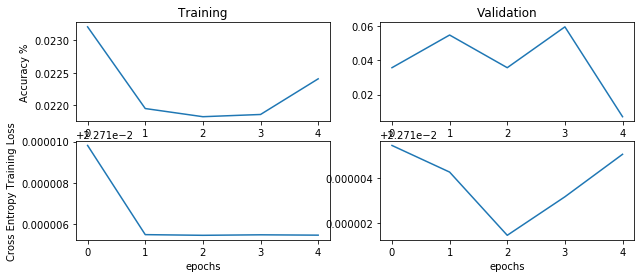

In [41]:
plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(cnn4_hist.history['accuracy'])

plt.ylabel('Accuracy %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(cnn4_hist.history['val_accuracy'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(cnn4_hist.history['loss'])
plt.ylabel('Cross Entropy Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(cnn4_hist.history['val_loss'])
plt.xlabel('epochs')

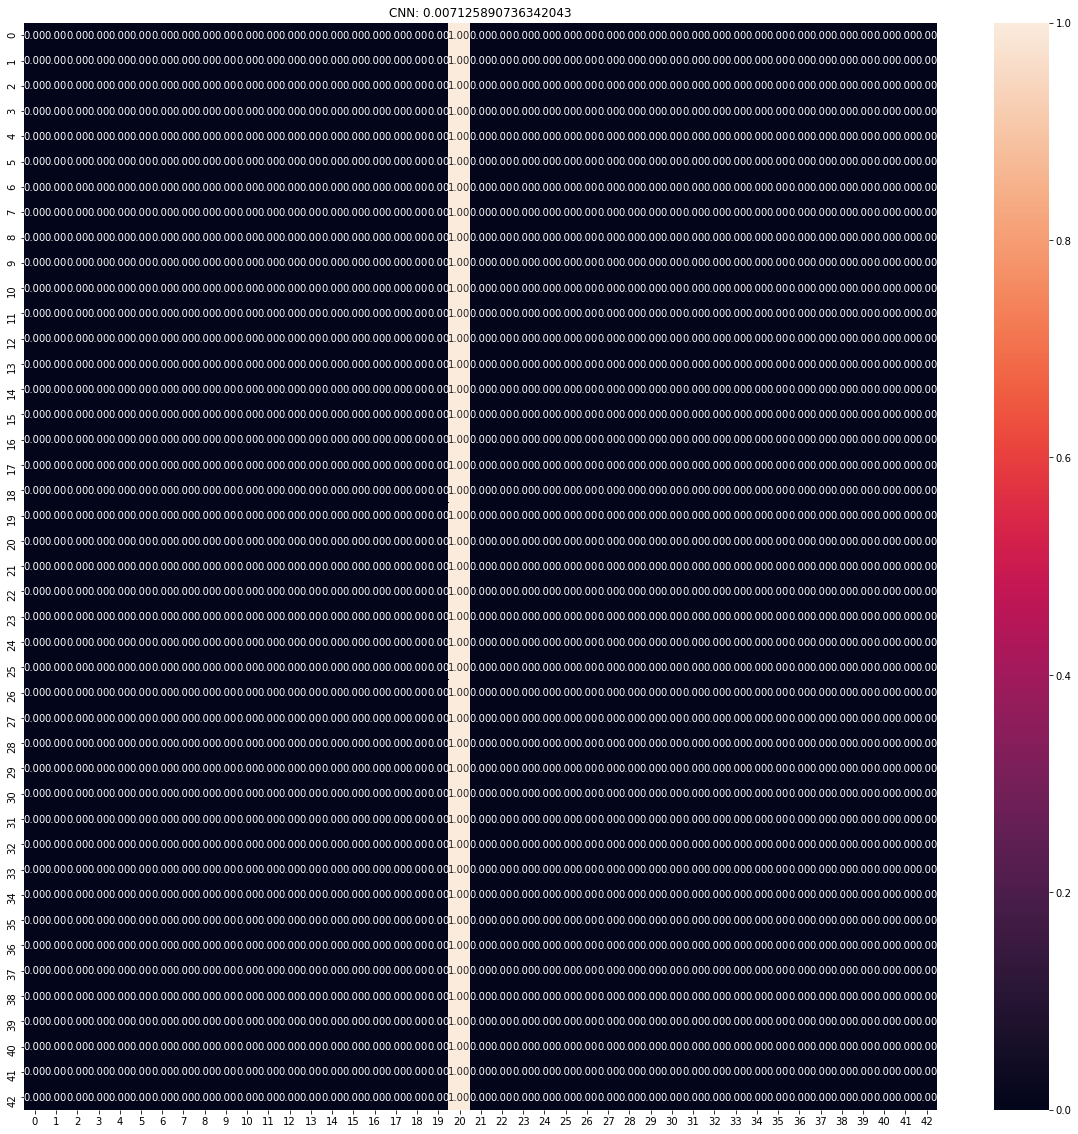

In [42]:
cnn_heatmap(cnn4,X_test_tr,y_test_tr)

### MLP Comparison

In [49]:
%%time

y_train_ohe_tr = keras.utils.to_categorical(y_train_tr, 43)
y_test_ohe_tr = keras.utils.to_categorical(y_test_tr, 43)

# make a 3 layer keras MLP
mlp = Sequential()
mlp.add(Flatten())
mlp.add( Dense(input_dim=X_train_tr.shape[1], units=30, activation='relu') )
mlp.add( Dense(units=15, activation='relu') )
mlp.add( Dense(43) )
mlp.add( Activation('softmax') )

mlp.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

Wall time: 209 ms


In [53]:
mlp.fit(X_train_tr, y_train_ohe_tr, 
        batch_size=32, epochs=50, 
        shuffle=True, verbose=1,
        )

Epoch 1/75
86989/86989 [==============================] - 9s 106us/step - loss: 0.0026 - accuracy: 0.9300
Epoch 2/75
86989/86989 [==============================] - 9s 102us/step - loss: 0.0026 - accuracy: 0.9297
Epoch 3/75
86989/86989 [==============================] - 8s 95us/step - loss: 0.0025 - accuracy: 0.9310
Epoch 4/75
86989/86989 [==============================] - 9s 101us/step - loss: 0.0025 - accuracy: 0.9305
Epoch 5/75
86989/86989 [==============================] - 8s 96us/step - loss: 0.0025 - accuracy: 0.9310
Epoch 6/75
86989/86989 [==============================] - 8s 95us/step - loss: 0.0025 - accuracy: 0.9323
Epoch 7/75
86989/86989 [==============================] - 8s 97us/step - loss: 0.0025 - accuracy: 0.9335
Epoch 8/75
86989/86989 [==============================] - 8s 97us/step - loss: 0.0025 - accuracy: 0.9336
Epoch 9/75
86989/86989 [==============================] - 8s 97us/step - loss: 0.0025 - accuracy: 0.9324
Epoch 10/75
86989/86989 [===========================

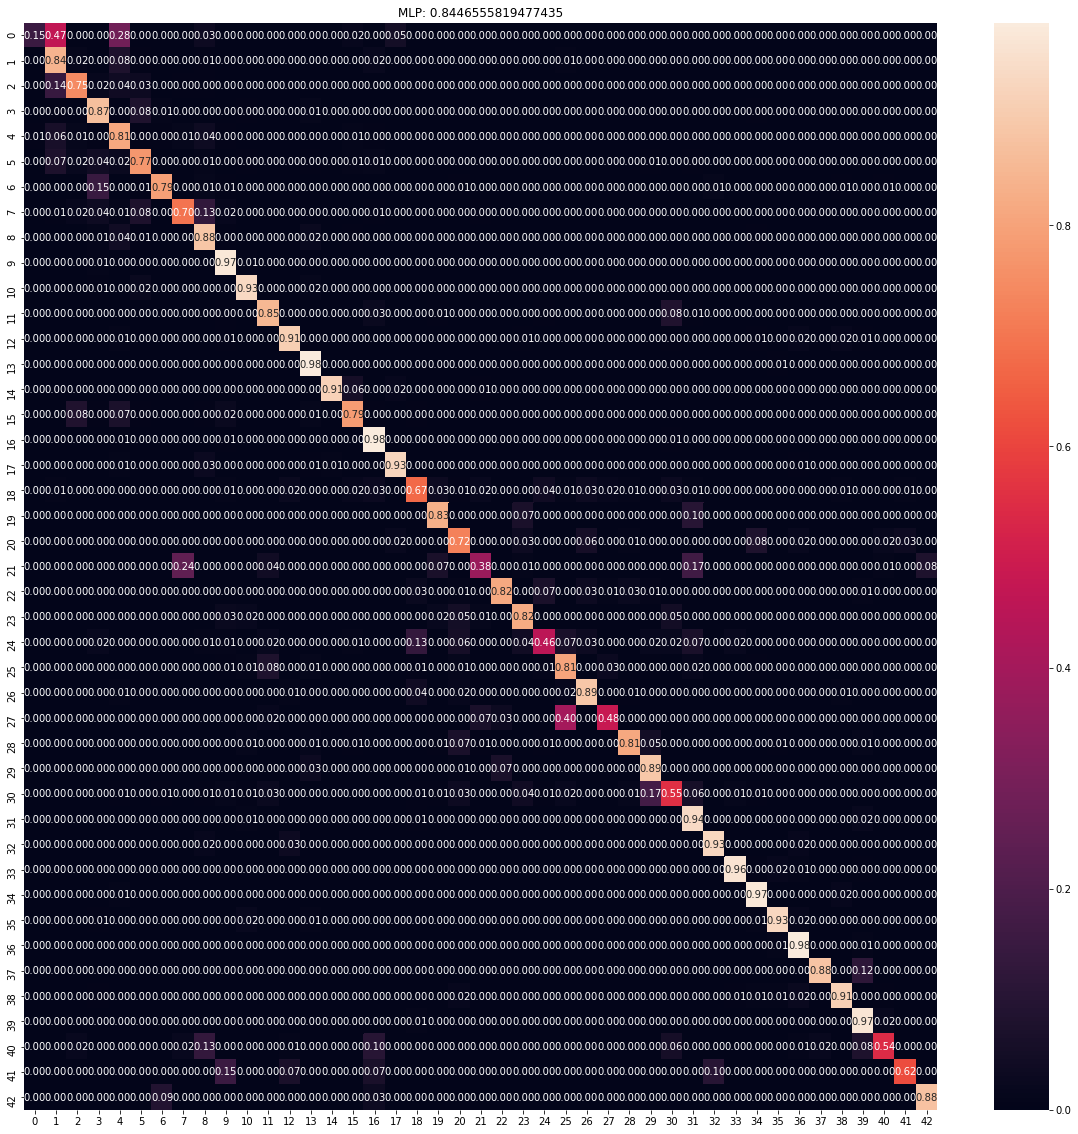

In [58]:
compare_mlp_cnn(None,mlp,X_test_tr,y_test_tr)

### TRAFFIC DATA

In [5]:
file_train = open("./data/traffic/train.pickle", "rb")
data_train = pickle.load(file_train) 
file_test = open("./data/traffic/test.pickle", "rb")
data_test = pickle.load(file_test) 
file_val = open("./data/traffic/test.pickle", "rb")
data_val = pickle.load(file_val) 

In [54]:
data_train.keys()

dict_keys(['coords', 'labels', 'features', 'sizes'])

In [51]:
for i in data_train['size']:
    print(i)

array([ 25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 175, 176, 177, 178, 179, 180, 181,
       182, 183, 184, 185, 187, 188, 189, 190, 191, 192, 193, 194, 195,
       196, 197, 199, 200, 201, 203, 205, 207, 208, 211, 213, 21

In [6]:
data_train['features'].shape

(34799, 32, 32, 3)

In [46]:
data_test['features'].shape

(12630, 32, 32, 3)

In [47]:
data_val['features'].shape

(12630, 32, 32, 3)

In [ ]:
X_train = data_train['features']
X_test = data_test['features']
y_train = data_train['labels']
y_test = data_test['labels']